In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
from argparse import ArgumentParser

import pytorch_lightning as pl
from torch_geometric.loader import DataLoader

from datasets import ArgoverseV2Dataset
from predictors import QCNet
from predictors.autoval import AntoQCNet
from transforms import TargetBuilder

pl.seed_everything(2023, workers=True)

parser = ArgumentParser()
parser.add_argument("--model", type=str, default="QCNet")
parser.add_argument("--root", type=str, default="/home/guanren/Multi-agent-competitive-environment/datasets")
parser.add_argument("--batch_size", type=int, default=1)
parser.add_argument("--num_workers", type=int, default=8)
parser.add_argument("--pin_memory", type=bool, default=True)
parser.add_argument("--persistent_workers", type=bool, default=True)
parser.add_argument("--accelerator", type=str, default="auto")
parser.add_argument("--devices", type=int, default=1)
parser.add_argument("--ckpt_path", default="checkpoints/epoch=10-step=274879.ckpt", type=str)
args = parser.parse_args("")

model = {
    "QCNet": AntoQCNet,
}[args.model].load_from_checkpoint(checkpoint_path=args.ckpt_path)
val_dataset = {
    "argoverse_v2": ArgoverseV2Dataset,
}[model.dataset](
    root=args.root,
    split="val",
    transform=TargetBuilder(model.num_historical_steps, model.num_future_steps),
)


Global seed set to 2023
/home/guanren/anaconda3/envs/QCNet/lib/python3.8/site-packages/pytorch_lightning/utilities/migration/utils.py:51: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.1.1, which is newer than your current Lightning version: v2.0.4
  rank_zero_warn(


In [3]:
dataloader = DataLoader(
    val_dataset[[val_dataset.raw_file_names.index('0a0ef009-9d44-4399-99e6-50004d345f34')]],
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=args.pin_memory,
    persistent_workers=args.persistent_workers,
)

trainer = pl.Trainer(accelerator=args.accelerator, devices=args.devices)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [4]:
it = iter(dataloader)
data = next(it)

/home/guanren/anaconda3/envs/QCNet/lib/python3.8/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


In [5]:
import io
import math
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as img
from typing import Final
from random import choices
from av2.datasets.motion_forecasting import scenario_serialization
from av2.datasets.motion_forecasting.data_schema import (
    ArgoverseScenario,
    ObjectType,
    TrackCategory,
)


_DRIVABLE_AREA_COLOR: Final[str] = "#7A7A7A"
_LANE_SEGMENT_COLOR: Final[str] = "#E0E0E0"

_DEFAULT_ACTOR_COLOR: Final[str] = "#D3E8EF"
_FOCAL_AGENT_COLOR: Final[str] = "#ECA25B"
_AV_COLOR: Final[str] = "#007672"
_BOUNDING_BOX_ZORDER: Final[
    int
] = 100  # Ensure actor bounding boxes are plotted on top of all map elements

_STATIC_OBJECT_TYPES = {
    ObjectType.STATIC,
    ObjectType.BACKGROUND,
    ObjectType.CONSTRUCTION,
    ObjectType.RIDERLESS_BICYCLE,
}
_ESTIMATED_VEHICLE_LENGTH_M: Final[float] = 4.0
_ESTIMATED_VEHICLE_WIDTH_M: Final[float] = 2.0
_ESTIMATED_CYCLIST_LENGTH_M: Final[float] = 2.0
_ESTIMATED_CYCLIST_WIDTH_M: Final[float] = 0.7


from matplotlib.patches import Rectangle
from av2.map.map_api import ArgoverseStaticMap
from av2.datasets.motion_forecasting.data_schema import (
    ArgoverseScenario,
    ObjectType,
    TrackCategory,
)


def _plot_static_map_elements(
    static_map: ArgoverseStaticMap, show_ped_xings: bool = False
) -> None:
    """Plot all static map elements associated with an Argoverse scenario.

    Args:
        static_map: Static map containing elements to be plotted.
        show_ped_xings: Configures whether pedestrian crossings should be plotted.
    """
    # Plot drivable areas
    for drivable_area in static_map.vector_drivable_areas.values():
        _plot_polygons([drivable_area.xyz], alpha=0.5, color=_DRIVABLE_AREA_COLOR)

    # Plot lane segments
    for lane_segment in static_map.vector_lane_segments.values():
        _plot_polylines(
            [
                lane_segment.left_lane_boundary.xyz,
                lane_segment.right_lane_boundary.xyz,
            ],
            line_width=0.5,
            color=_LANE_SEGMENT_COLOR,
        )

    # Plot pedestrian crossings
    if show_ped_xings:
        for ped_xing in static_map.vector_pedestrian_crossings.values():
            _plot_polylines(
                [ped_xing.edge1.xyz, ped_xing.edge2.xyz],
                alpha=1.0,
                color=_LANE_SEGMENT_COLOR,
            )


def _plot_actor_tracks(ax: plt.Axes, scenario, timestep: int):
    """Plot all actor tracks (up to a particular time step) associated with an Argoverse scenario.

    Args:
        ax: Axes on which actor tracks should be plotted.
        scenario: Argoverse scenario for which to plot actor tracks.
        timestep: Tracks are plotted for all actor data up to the specified time step.

    Returns:
        track_bounds: (x_min, x_max, y_min, y_max) bounds for the extent of actor tracks.
    """
    track_bounds = None
    for track in scenario.tracks:
        # Get timesteps for which actor data is valid
        actor_timesteps = np.array(
            [
                object_state.timestep
                for object_state in track.object_states
                if object_state.timestep <= timestep
            ]
        )
        if actor_timesteps.shape[0] < 1 or actor_timesteps[-1] != timestep:
            continue

        # Get actor trajectory and heading history
        actor_trajectory = np.array(
            [
                list(object_state.position)
                for object_state in track.object_states
                if object_state.timestep <= timestep
            ]
        )
        actor_headings: NDArrayFloat = np.array(
            [
                object_state.heading
                for object_state in track.object_states
                if object_state.timestep <= timestep
            ]
        )

        # Plot polyline for focal agent location history
        track_color = _DEFAULT_ACTOR_COLOR
        if track.category == TrackCategory.FOCAL_TRACK:
            x_min, x_max = actor_trajectory[:, 0].min(), actor_trajectory[:, 0].max()
            y_min, y_max = actor_trajectory[:, 1].min(), actor_trajectory[:, 1].max()
            track_bounds = (x_min, x_max, y_min, y_max)
            track_color = _FOCAL_AGENT_COLOR
            _plot_polylines(
                [
                    np.array(
                        [
                            list(object_state.position)
                            for object_state in track.object_states
                            if object_state.timestep > timestep
                        ]
                    )
                ],
                color="black",
                line_width=2,
                style="--",
            )
            _plot_polylines([actor_trajectory], color=track_color, line_width=2)
        elif track.track_id == "AV":
            track_color = _AV_COLOR
        elif track.object_type in _STATIC_OBJECT_TYPES:
            continue

        # Plot bounding boxes for all vehicles and cyclists
        if track.object_type == ObjectType.VEHICLE:
            _plot_actor_bounding_box(
                ax,
                actor_trajectory[-1],
                actor_headings[-1],
                track_color,
                (_ESTIMATED_VEHICLE_LENGTH_M, _ESTIMATED_VEHICLE_WIDTH_M),
            )
        elif (
            track.object_type == ObjectType.CYCLIST
            or track.object_type == ObjectType.MOTORCYCLIST
        ):
            _plot_actor_bounding_box(
                ax,
                actor_trajectory[-1],
                actor_headings[-1],
                track_color,
                (_ESTIMATED_CYCLIST_LENGTH_M, _ESTIMATED_CYCLIST_WIDTH_M),
            )
        else:
            plt.plot(
                actor_trajectory[-1, 0],
                actor_trajectory[-1, 1],
                "o",
                color=track_color,
                markersize=4,
            )

    return track_bounds


def _plot_polylines(
    polylines,
    *,
    style: str = "-",
    line_width: float = 1.0,
    alpha: float = 1.0,
    color: str = "r",
) -> None:
    """Plot a group of polylines with the specified config.

    Args:
        polylines: Collection of (N, 2) polylines to plot.
        style: Style of the line to plot (e.g. `-` for solid, `--` for dashed)
        line_width: Desired width for the plotted lines.
        alpha: Desired alpha for the plotted lines.
        color: Desired color for the plotted lines.
    """
    for polyline in polylines:
        plt.plot(
            polyline[:, 0],
            polyline[:, 1],
            style,
            linewidth=line_width,
            color=color,
            alpha=alpha,
        )


def _plot_polygons(polygons, *, alpha: float = 1.0, color: str = "r") -> None:
    """Plot a group of filled polygons with the specified config.

    Args:
        polygons: Collection of polygons specified by (N,2) arrays of vertices.
        alpha: Desired alpha for the polygon fill.
        color: Desired color for the polygon.
    """
    for polygon in polygons:
        plt.fill(polygon[:, 0], polygon[:, 1], color=color, alpha=alpha)


def _plot_actor_bounding_box(
    ax: plt.Axes, cur_location, heading: float, color: str, bbox_size
) -> None:
    """Plot an actor bounding box centered on the actor's current location.

    Args:
        ax: Axes on which actor bounding box should be plotted.
        cur_location: Current location of the actor (2,).
        heading: Current heading of the actor (in radians).
        color: Desired color for the bounding box.
        bbox_size: Desired size for the bounding box (length, width).
    """
    (bbox_length, bbox_width) = bbox_size

    # Compute coordinate for pivot point of bounding box
    d = np.hypot(bbox_length, bbox_width)
    theta_2 = math.atan2(bbox_width, bbox_length)
    pivot_x = cur_location[0] - (d / 2) * math.cos(heading + theta_2)
    pivot_y = cur_location[1] - (d / 2) * math.sin(heading + theta_2)

    vehicle_bounding_box = Rectangle(
        (pivot_x, pivot_y),
        bbox_length,
        bbox_width,
        np.degrees(heading),
        color=color,
        zorder=_BOUNDING_BOX_ZORDER,
    )
    ax.add_patch(vehicle_bounding_box)

In [6]:
scenario_id = data["scenario_id"][0]
argoverse_scenario_dir = Path("/home/guanren/Multi-agent-competitive-environment/datasets/val/raw")

all_scenario_files = sorted(argoverse_scenario_dir.rglob(f"*_{scenario_id}.parquet"))
scenario_file_list = list(all_scenario_files)
scenario_path = scenario_file_list[0]
print(scenario_path)

static_map_path = scenario_path.parents[0] / f"log_map_archive_{scenario_id}.json"

scenario = scenario_serialization.load_argoverse_scenario_parquet(scenario_path)
scenario_static_map = ArgoverseStaticMap.from_json(static_map_path)

/home/guanren/Multi-agent-competitive-environment/datasets/val/raw/8ff85423-3f41-49c1-b81f-dfabd54a1a90/scenario_8ff85423-3f41-49c1-b81f-dfabd54a1a90.parquet


/tmp/ipykernel_205390/1622738850.py:243: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  vehicle_bounding_box = Rectangle(


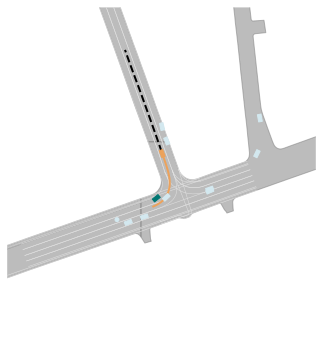

In [7]:
def plot_traj(bounds=80.0):
    plot_bounds = (0, 0, 0, 0)

    _, ax = plt.subplots()

    _plot_static_map_elements(scenario_static_map)
    cur_plot_bounds = _plot_actor_tracks(ax, scenario, 50)
    if cur_plot_bounds:
        plot_bounds = cur_plot_bounds
    plt.xlim(
        plot_bounds[0] - bounds,
        plot_bounds[1] + bounds,
    )
    plt.ylim(
        plot_bounds[2] - bounds,
        plot_bounds[3] + bounds,
    )
    plt.gca().set_aspect("equal", adjustable="box")
    plt.gca().set_axis_off()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

plot_traj()



In [18]:

for param in model.encoder.parameters():
        param.requires_grad = False
for param in model.decoder.parameters():
        param.requires_grad = False

from torch_geometric.data import Batch
from utils import wrap_angle
import torch
import copy
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points

if isinstance(data, Batch):
    data['agent']['av_index'] += data['agent']['ptr'][:-1]

def get_transform_mat(input_data):
    origin = input_data["agent"]["position"][:, model.num_historical_steps - 1]
    theta = input_data["agent"]["heading"][:, model.num_historical_steps - 1]
    cos, sin = theta.cos(), theta.sin()
    rot_mat = theta.new_zeros(input_data["agent"]["num_nodes"], 2, 2)
    rot_mat[:, 0, 0] = cos
    rot_mat[:, 0, 1] = -sin
    rot_mat[:, 1, 0] = sin
    rot_mat[:, 1, 1] = cos
    return origin,theta,rot_mat
init_origin,init_theta,init_rot_mat=get_transform_mat(data)
def get_auto_pred(input_data, loc_refine_pos, loc_refine_head, offset, anchor=None):
    old_anchor=origin,theta,rot_mat=get_transform_mat(input_data)
    # auto_index = data['agent']['valid_mask'][:,model.num_historical_steps]
    input_data["agent"]["valid_mask"] = (
        torch.cat(
            (
                input_data["agent"]["valid_mask"][..., offset:],
                torch.zeros(input_data["agent"]["valid_mask"].shape[:-1] + (5,)).cuda(),
            ),
            dim=-1,
        )
    ).bool()
    input_data["agent"]["valid_mask"][:, 0] = False
    new_position = torch.matmul(
        loc_refine_pos[..., :2], rot_mat.swapaxes(-1, -2)
    ) + origin[:, :2].unsqueeze(1)
    input_position = torch.zeros_like(input_data["agent"]["position"])
    input_position[:, :-offset] = input_data["agent"]["position"][:, offset:]
    input_position[
        :, model.num_historical_steps - offset : model.num_historical_steps, :2
    ] = new_position[:, :offset]

    input_v = torch.zeros_like(input_data["agent"]["velocity"])
    input_v[:, :-offset] = input_data["agent"]["velocity"][:, offset:]
    input_v[:, model.num_historical_steps - offset : model.num_historical_steps, :2] = (
        new_position[:, 1:] - new_position[:, :-1]
    )[:, :offset] / 0.1
    
    

    input_heading = torch.zeros_like(input_data["agent"]["heading"])
    input_heading[:, :-offset] = input_data["agent"]["heading"][:, offset:]
    input_heading[
        :, model.num_historical_steps - offset : model.num_historical_steps
    ] = wrap_angle(loc_refine_head+theta.unsqueeze(-1))[:,:offset]
    input_data["agent"]["position"] = input_position
    input_data["agent"]["heading"] = input_heading
    input_data["agent"]["velocity"] = input_v

    auto_pred = model(input_data)
    new_anchor=get_transform_mat(input_data)
    def get_transform_res(old_anchor,new_anchor,auto_pred):
        old_origin,old_theta,old_rot_mat=old_anchor
        new_origin,new_theta,new_rot_mat=new_anchor
        new_trans_position_propose = torch.einsum(
            "bijk,bkn->bijn",
            auto_pred["loc_propose_pos"][..., : model.output_dim],
            new_rot_mat.swapaxes(-1, -2),
        ) + new_origin[:, :2].unsqueeze(1).unsqueeze(1)
        new_pred=copy.deepcopy(auto_pred)
        new_pred["loc_propose_pos"][..., : model.output_dim] = torch.einsum(
            "bijk,bkn->bijn",
            new_trans_position_propose.cuda() - old_origin[:, :2].unsqueeze(1).unsqueeze(1).cuda(),
            old_rot_mat.cuda(),
        )
        new_pred["scale_propose_pos"][..., model.output_dim - 1] = wrap_angle(
            auto_pred["scale_propose_pos"][..., model.output_dim - 1].cuda()
            + new_theta.unsqueeze(-1).unsqueeze(-1).cuda()
            - old_theta.unsqueeze(-1).unsqueeze(-1).cuda()
        )

        new_trans_position_refine = torch.einsum(
            "bijk,bkn->bijn",
            auto_pred["loc_refine_pos"][..., : model.output_dim].cuda(),
            new_rot_mat.swapaxes(-1, -2).cuda(),
        ) + new_origin[:, :2].unsqueeze(1).unsqueeze(1).cuda()
        new_pred["loc_refine_pos"][..., : model.output_dim] = torch.einsum(
            "bijk,bkn->bijn",
            new_trans_position_refine.cuda() - old_origin[:, :2].unsqueeze(1).unsqueeze(1).cuda(),
            old_rot_mat.cuda(),
        )
        new_pred["scale_refine_pos"][..., model.output_dim - 1] = wrap_angle(
            auto_pred["scale_refine_pos"][..., model.output_dim - 1].cuda()
            + new_theta.unsqueeze(-1).unsqueeze(-1).cuda()
            - old_theta.unsqueeze(-1).unsqueeze(-1).cuda()
        )
        return new_pred,(new_trans_position_propose, new_trans_position_refine),

    _,(new_trans_position_propose, new_trans_position_refine)=get_transform_res(old_anchor,new_anchor,auto_pred)
    if model.output_head:
        auto_traj_propose = torch.cat(
            [
                auto_pred["loc_propose_pos"][..., : model.output_dim],
                auto_pred["loc_propose_head"],
                auto_pred["scale_propose_pos"][..., : model.output_dim],
                auto_pred["conc_propose_head"],
            ],
            dim=-1,
        )
        auto_traj_refine = torch.cat(
            [
                auto_pred["loc_refine_pos"][..., : model.output_dim],
                auto_pred["loc_refine_head"],
                auto_pred["scale_refine_pos"][..., : model.output_dim],
                auto_pred["conc_refine_head"],
            ],
            dim=-1,
        )
    else:
        auto_traj_propose = torch.cat([auto_pred['loc_propose_pos'][..., :model.output_dim],
                                auto_pred['scale_propose_pos'][..., :model.output_dim]], dim=-1)
        auto_traj_refine = torch.cat([auto_pred['loc_refine_pos'][..., :model.output_dim],
                                auto_pred['scale_refine_pos'][..., :model.output_dim]], dim=-1)
    if anchor is not None:
        anchor_auto_pred,_=get_transform_res(anchor,new_anchor,auto_pred)
        if model.output_head:
            anchor_auto_traj_propose = torch.cat([anchor_auto_pred['loc_propose_pos'][..., :model.output_dim],
                                                  anchor_auto_pred["loc_propose_head"],
                                    anchor_auto_pred['scale_propose_pos'][..., :model.output_dim],
                                    anchor_auto_pred["conc_propose_head"],], dim=-1)
            anchor_auto_traj_refine = torch.cat([anchor_auto_pred['loc_refine_pos'][..., :model.output_dim],
                                                 anchor_auto_pred["loc_refine_head"],
                                    anchor_auto_pred['scale_refine_pos'][..., :model.output_dim],
                                    anchor_auto_pred["conc_refine_head"],], dim=-1)
        else:
            anchor_auto_traj_propose = torch.cat([anchor_auto_pred['loc_propose_pos'][..., :model.output_dim],
                                    anchor_auto_pred['scale_propose_pos'][..., :model.output_dim]], dim=-1)
            anchor_auto_traj_refine = torch.cat([anchor_auto_pred['loc_refine_pos'][..., :model.output_dim],
                                    anchor_auto_pred['scale_refine_pos'][..., :model.output_dim]], dim=-1)

    return (
        input_data,
        auto_pred,
        auto_traj_refine,
        auto_traj_propose,
        (new_trans_position_propose, new_trans_position_refine),
        None if anchor is None else (anchor_auto_traj_propose, anchor_auto_traj_refine)
    )

def reward_function(new_data,agent_index,timestep):
                
        reward1 = reward2 = reward3 = 0

        pre_v = new_data['agent']['velocity'][agent_index, model.num_historical_steps-2:model.num_historical_steps-1, :model.output_dim]
        next_v = new_data['agent']['velocity'][agent_index, model.num_historical_steps-1:model.num_historical_steps, :model.output_dim]

        pre_v = math.sqrt(pre_v[0,0]**2+pre_v[0,1]**2)
        next_v = math.sqrt(next_v[0,0]**2+next_v[0,1]**2)
        
        if next_v > pre_v:
             reward1 = 50
        else:
             reward1 = -50

        for i in range(data['agent']['num_nodes']):
            if i==agent_index:
                continue
            distance = torch.norm(new_data['agent']['position'][agent_index, model.num_historical_steps-1:model.num_historical_steps, :model.output_dim]-new_data['agent']['position'][i, model.num_historical_steps-1:model.num_historical_steps, :model.output_dim],dim=-1)
            if distance < 1e-1:
                 break
        if distance < 1e-1:
            reward2 = -100
        left_bound = []
        right_bound = []
        for i in range(len(data['map_point']['side'])):
            if data['map_point']['side'][i] == 0:
                left_bound.append(tuple(data['map_point']['position'][i,:2]))
            if data['map_point']['side'][i] == 1:
                right_bound.append(tuple(data['map_point']['position'][i,:2]))
        left_polygon = LineString(left_bound)
        right_polygon = LineString(right_bound)
        car_point = Point(tuple(new_data['agent']['position'][agent_index, model.num_historical_steps-1:model.num_historical_steps, :model.output_dim].flatten().cpu().numpy()))
        nearest_left = nearest_points(left_polygon, car_point)[0]
        nearest_right = nearest_points(right_polygon, car_point)[0]
        distance_to_nearest_left = car_point.distance(nearest_left)
        distance_to_nearest_right = car_point.distance(nearest_right)
        lane_width = nearest_left.distance(nearest_right)
        if distance_to_nearest_left + distance_to_nearest_right > lane_width:
            reward3 = -50

        # total_reward = np.array([reward1, reward2, reward3])
        # mean_reward = np.mean(total_reward)
        # std_reward = np.std(total_reward)    
        # normalized_reward = (total_reward - mean_reward) / std_reward
        # return float(np.sum(normalized_reward))
        return reward1+reward2+reward3

/tmp/ipykernel_205390/1622738850.py:243: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  vehicle_bounding_box = Rectangle(


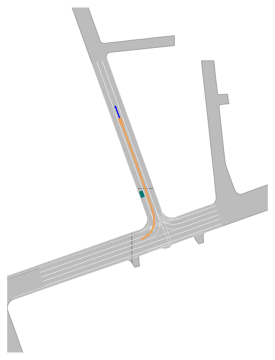

In [19]:
def _plot_actor_tracks_with_data(ax: plt.Axes, data, timestep: int):
    """Plot all actor tracks (up to a particular time step) associated with an Argoverse scenario.

    Args:
        ax: Axes on which actor tracks should be plotted.
        scenario: Argoverse scenario for which to plot actor tracks.
        timestep: Tracks are plotted for all actor data up to the specified time step.

    Returns:
        track_bounds: (x_min, x_max, y_min, y_max) bounds for the extent of actor tracks.
    """
    track_bounds = None
    for i in range(data['agent']['num_nodes']):
        if not (data['agent']['valid_mask'][i,timestep]):
            continue
        # Get timesteps for which actor data is valid
        track_color = _DEFAULT_ACTOR_COLOR
        
        # Get actor trajectory and heading history

        actor_trajectory = data['agent']['position'][i,:timestep+1][data['agent']['valid_mask'][i,:timestep+1]].cpu()
        actor_headings = data['agent']['heading'][i,:timestep+1][data['agent']['valid_mask'][i,:timestep+1]].cpu()


        if data['agent']['category'][i] == TrackCategory.FOCAL_TRACK.value:
            x_min, x_max = actor_trajectory[:, 0].min(), actor_trajectory[:, 0].max()
            y_min, y_max = actor_trajectory[:, 1].min(), actor_trajectory[:, 1].max()
            track_bounds = (x_min, x_max, y_min, y_max)
            track_color = _FOCAL_AGENT_COLOR
            _plot_polylines([actor_trajectory], color=track_color, line_width=2)
            ax.arrow(actor_trajectory[-1,0], actor_trajectory[-1,1], data['agent']['velocity'][i,timestep,0].cpu(),data['agent']['velocity'][i,timestep,1].cpu(),
              width=0.1,
              length_includes_head=True,
              head_width=0.75,
              head_length=1,
              fc='r',
              ec='b')
        elif i==data['agent']['av_index']:
            track_color = _AV_COLOR
        elif i==data['agent']['num_nodes']-1:
            _plot_polylines([actor_trajectory], color="black", line_width=2)
            track_color = "black"
            ax.arrow(actor_trajectory[-1,0], actor_trajectory[-1,1], data['agent']['velocity'][i,timestep,0].cpu(),data['agent']['velocity'][i,timestep,1].cpu(),
              width=0.1,
              length_includes_head=True,
              head_width=0.75,
              head_length=1,
              fc='r',
              ec='y')
        elif data['agent']['type'][i]>4:
            continue

        # Plot bounding boxes for all vehicles and cyclists
        if data['agent']['type'][i]==0:
            _plot_actor_bounding_box(
                ax,
                actor_trajectory[-1],
                actor_headings[-1],
                track_color,
                (_ESTIMATED_VEHICLE_LENGTH_M, _ESTIMATED_VEHICLE_WIDTH_M),
            )
        elif (
            data['agent']['type'][i]==2
            or data['agent']['type'][i]==3
        ):
            _plot_actor_bounding_box(
                ax,
                actor_trajectory[-1],
                actor_headings[-1],
                track_color,
                (_ESTIMATED_CYCLIST_LENGTH_M, _ESTIMATED_CYCLIST_WIDTH_M),
            )
        else:
            plt.plot(
                actor_trajectory[-1, 0],
                actor_trajectory[-1, 1],
                "o",
                color=track_color,
                markersize=4,
            )

    return track_bounds



def plot_traj_with_data(data,t=50,bounds=80.0):
    plot_bounds = (0, 0, 0, 0)

    _, ax = plt.subplots()

    _plot_static_map_elements(scenario_static_map)
    cur_plot_bounds = _plot_actor_tracks_with_data(ax, data, t)
    if cur_plot_bounds:
        plot_bounds = cur_plot_bounds
    plt.xlim(
        plot_bounds[0] - bounds,
        plot_bounds[1] + bounds,
    )
    plt.ylim(
        plot_bounds[2] - bounds,
        plot_bounds[3] + bounds,
    )
    plt.gca().set_aspect("equal", adjustable="box")
    plt.gca().set_axis_off()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())


plot_traj_with_data(data,t=105)

/tmp/ipykernel_205390/1622738850.py:243: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  vehicle_bounding_box = Rectangle(


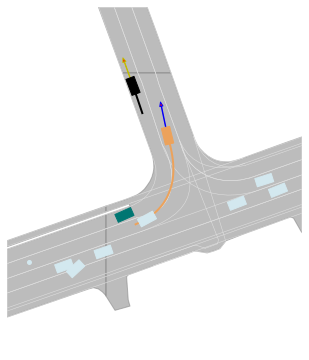

In [20]:
acceleration = 1.5
arr_s_x = np.array([])
arr_s_y = np.array([])
arr_v_x = np.array([])
arr_v_y = np.array([])
v0_x = 5*math.cos(data['agent']['heading'][data['agent']['category']==3][0,50])
v0_y = 5
t = 0.1
x0 = x = 5258.5
y0 = y = 320.6
v_x = 0
v_y = 0
new_heading=torch.empty_like(data['agent']['heading'][0])
new_heading[:]=1.9338

for i in range(80):
    a_x = acceleration*math.cos(new_heading[i+30])
    x = x + v0_x*t + 0.5*acceleration*(t**2)
    v0_x = v0_x + a_x*t
    v_x = v0_x
    arr_s_x = np.append(arr_s_x,x)
    arr_v_x = np.append(arr_v_x,v_x)

    a_y = math.sqrt(acceleration**2-a_x**2)
    y = y + v0_y*t + 0.5*acceleration*(t**2)
    v0_y = v0_y + a_y*t
    v_y = v0_y
    arr_s_y = np.append(arr_s_y,y)
    arr_v_y = np.append(arr_v_y,v_y)

new_position=torch.empty_like(data['agent']['position'][0])
new_position[:,0]=torch.tensor(np.concatenate([np.ones(30)*x0,arr_s_x]))
new_position[:,1]=torch.tensor(np.concatenate([np.ones(30)*y0,arr_s_y]))

new_velocity=torch.empty_like(data['agent']['velocity'][0])
new_velocity[:,0]=torch.tensor(np.concatenate([np.ones(30)*0,arr_v_x]))
new_velocity[:,1]=torch.tensor(np.concatenate([np.ones(30)*0,arr_v_y]))

def add_new_agent(data,new_position,new_heading,new_velocity):
    data=data.clone()
    data['agent']['num_nodes']+=1   #num_nodes
    #av_index
    data['agent']['valid_mask']=torch.cat([data['agent']['valid_mask'],torch.ones_like(data['agent']['valid_mask'][[0]])]) #valid_mask
    data['agent']['predict_mask']=torch.cat([data['agent']['predict_mask'],torch.ones_like(data['agent']['predict_mask'][[0]])]) #predict_mask
    data['agent']['id'][0].append(str(max(map(int,filter(str.isdigit,data['agent']['id'][0])))+1)) #id
    data['agent']['type']=torch.cat([data['agent']['type'],torch.tensor([0])]) #type
    data['agent']['category']=torch.cat([data['agent']['category'],torch.tensor([2])]) #category
    data['agent']['position']=torch.cat([data['agent']['position'],new_position[None,:]]) #position
    data['agent']['heading']=torch.cat([data['agent']['heading'],new_heading[None,:]]) #heading
    data['agent']['velocity']=torch.cat([data['agent']['velocity'],new_velocity[None,:]]) #velocity
    #target
    data['agent']['batch']=torch.cat([data['agent']['batch'],torch.tensor([0])]) #batch
    data['agent']['ptr'][1]+=1    #ptr
    return data
new_input_data=add_new_agent(data,new_position,new_heading,new_velocity)
plot_traj_with_data(new_input_data,bounds=30,t=40)
# new_input_data['agent']['valid_mask'][:]=False
# new_input_data['agent']['valid_mask'][new_input_data["agent"]["category"] == 3] = True
# new_input_data['agent']['valid_mask'][new_input_data["agent"]["category"] == 2] = True
# new_input_data['agent']['valid_mask'][2] = True

In [21]:
frames = []
with torch.no_grad():
    offset=5
    new_data=new_input_data.cuda().clone()
    pred = model(new_data)
    traj_propose = torch.cat([pred['loc_propose_pos'][..., :model.output_dim],
                            pred['scale_propose_pos'][..., :model.output_dim]], dim=-1)
    traj_refine = torch.cat([pred['loc_refine_pos'][..., :model.output_dim],
                            pred['scale_refine_pos'][..., :model.output_dim]], dim=-1)
    origin,theta,rot_mat=get_transform_mat(new_data)
    new_true_trans_position_refine = torch.einsum(
        "bijk,bkn->bijn",
        pred["loc_refine_pos"][..., : model.output_dim],
        rot_mat.swapaxes(-1, -2),
    ) + origin[:, :2].unsqueeze(1).unsqueeze(1)
    auto_pred=pred
    init_origin,init_theta,init_rot_mat=get_transform_mat(new_data)

    for i in range(30,110):
        if i<50:
            plot_traj_with_data(new_data,bounds=30,t=i)
        else:
            if i%offset==0:
                # true_trans_position_propose=new_true_trans_position_propose
                true_trans_position_refine=new_true_trans_position_refine
                # reg_mask = new_data['agent']['predict_mask'][:, model.num_historical_steps:]
                # cls_mask = new_data['agent']['predict_mask'][:, -1]
                # gt = torch.cat([data['agent']['target'][...,timestep:timestep+offset, :model.output_dim], data['agent']['target'][...,timestep:timestep+offset, -1:]], dim=-1)
                # l2_norm = (torch.norm(traj_propose[:-1,...,:offset, :model.output_dim] -
                #                     gt[..., :model.output_dim].unsqueeze(1), p=2, dim=-1) * reg_mask[:-1,...,:offset].unsqueeze(1)).sum(dim=-1)
                # best_mode = l2_norm.argmin(dim=-1)
                best_mode=torch.randint(1,size=(new_input_data['agent']['num_nodes'],))
                new_data, auto_pred, _, _, (new_true_trans_position_propose, new_true_trans_position_refine),(traj_propose, traj_refine) = get_auto_pred(
                    new_data, auto_pred["loc_refine_pos"][torch.arange(traj_propose.size(0)),best_mode], auto_pred["loc_refine_head"][torch.arange(traj_propose.size(0)),best_mode,:,0], offset,anchor=(init_origin,init_theta,init_rot_mat)
                )
                plot_traj_with_data(new_data,bounds=30,t=50-offset)
            else:
                plot_traj_with_data(new_data,bounds=30,t=50-offset+i%offset)
            for j in range(6):
                xy = true_trans_position_refine[new_data["agent"]["category"] == 3][0].cpu()
                plt.plot(xy[j, ..., 0], xy[j, ..., 1])

        plt.title(f"timestep={i}")
        buf = io.BytesIO()
        plt.savefig(buf, format="png")
        plt.close()
        buf.seek(0)
        frame = img.open(buf)
        frames.append(frame)
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
vid_path = "test.mp4"
video = cv2.VideoWriter(vid_path, fourcc, fps=10, frameSize=frames[0].size)
for i in range(len(frames)):
    frame_temp = frames[i].copy()
    video.write(cv2.cvtColor(np.array(frame_temp), cv2.COLOR_RGB2BGR))
video.release()

/tmp/ipykernel_205390/1622738850.py:243: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  vehicle_bounding_box = Rectangle(


In [24]:
import torch
from PPO.mappo import PPO
import yaml

episodes = 50
cumulative_reward = [{'return': []} for _ in range(new_input_data['agent']['num_nodes'])]

with open("configs/PPO.yaml", "r") as file:
        config = yaml.safe_load(file)
file.close()

with torch.no_grad():
    for episode in range(episodes):
        offset=5
        new_data=new_input_data.cuda().clone()
        pred = model(new_data)
        traj_propose = torch.cat([pred['loc_propose_pos'][..., :model.output_dim],
                                pred['scale_propose_pos'][..., :model.output_dim]], dim=-1)
        traj_refine = torch.cat([pred['loc_refine_pos'][..., :model.output_dim],
                                pred['scale_refine_pos'][..., :model.output_dim]], dim=-1)
        final_traj_propose=torch.zeros_like(traj_propose)
        final_traj_refine=torch.zeros_like(traj_refine)
        true_traj_propose=torch.zeros_like(traj_propose)
        true_traj_refine=torch.zeros_like(traj_refine)
        auto_pred=pred

        transition_list = [{'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []} for _ in range(new_data['agent']['num_nodes'])]

        for timestep in range(0,model.num_future_steps,offset):
            reg_mask = new_data['agent']['predict_mask'][:, model.num_historical_steps:]
            cls_mask = new_data['agent']['predict_mask'][:, -1]
            # gt = torch.cat([data['agent']['target'][...,timestep:timestep+offset, :model.output_dim], data['agent']['target'][...,timestep:timestep+offset, -1:]], dim=-1)
            # l2_norm = (torch.norm(traj_propose[...,:offset, :model.output_dim] -
            #                     gt[..., :model.output_dim].unsqueeze(1), p=2, dim=-1) * reg_mask[...,:offset].unsqueeze(1)).sum(dim=-1)
            # best_mode = l2_norm.argmin(dim=-1)
            best_mode = torch.randint(1,size=(new_data['agent']['num_nodes'],))
                
            agent_index = torch.nonzero(new_data['agent']['category']==3,as_tuple=False).item()
            state = new_data['agent']['position'][agent_index, model.num_historical_steps - offset : model.num_historical_steps, :model.output_dim]
            state = torch.cat([state, new_data['agent']['velocity'][agent_index, model.num_historical_steps - offset : model.num_historical_steps, :model.output_dim]], dim = -1)
            next_state = new_data['agent']['position'][agent_index, model.num_historical_steps : model.num_historical_steps + offset, :model.output_dim]
            next_state = torch.cat([next_state, new_data['agent']['velocity'][agent_index, model.num_historical_steps : model.num_historical_steps + offset, :model.output_dim]], dim = -1)
                
            action = new_data['agent']['heading'][agent_index, model.num_historical_steps - offset : model.num_historical_steps]
            acceleration = (new_data['agent']['velocity'][agent_index, model.num_historical_steps : model.num_historical_steps + offset, :model.output_dim] - new_data['agent']['velocity'][agent_index, model.num_historical_steps - offset: model.num_historical_steps, :model.output_dim])/(0.1*offset)
            action = torch.cat([action.unsqueeze(-1), acceleration],dim=-1)
            # a = (a-torch.min(a))/(torch.max(a)-torch.min(a))
            # a = 2 * a - 1

            transition_list[agent_index]['states'].append(state)
            transition_list[agent_index]['actions'].append(action)
            transition_list[agent_index]['next_states'].append(next_state)

            transition_list[agent_index]['dones'].append(False)
            reward = reward_function(new_data, agent_index, offset)
            transition_list[agent_index]['rewards'].append(reward)
                    

            new_data, auto_pred, _, _, (true_trans_position_propose, true_trans_position_refine),(traj_propose, traj_refine) = get_auto_pred(
                new_data, auto_pred["loc_refine_pos"][torch.arange(traj_propose.size(0)),best_mode], auto_pred["loc_refine_head"][torch.arange(traj_propose.size(0)),best_mode,:,0], offset,anchor=(init_origin,init_theta,init_rot_mat)
            )
            true_traj_refine[:,:,timestep:timestep+offset,:2]=new_data["agent"]["position"][...,model.num_historical_steps - offset : model.num_historical_steps,:2].unsqueeze(1)
            pi = auto_pred['pi']


        agent_index = torch.nonzero(new_data['agent']['category']==3,as_tuple=False).item()
                
        agent = PPO(
                batch_id=0,
                encoder = model.encoder,
                decoder = model.decoder,
                data = new_data.clone().cuda(),
                agent_index = agent_index,
                hidden_dim = config['hidden_dim'],
                action_dim = model.output_dim+1,
                state_dim = model.output_dim*2,
                actor_learning_rate = config['actor_learning_rate'],
                critic_learning_rate = config['critic_learning_rate'],
                lamda = config['lamda'],
                eps = config['eps'],
                gamma = config['gamma'],
                device = model.device,
                agent_num = new_data['agent']['num_nodes'],
                offset = offset,
                entropy_coef=config['entropy_coef'],
                epochs = config['epochs']
        )
                
        agent.update(transition_list,agent_index)

        _return = 0
        for t in reversed(range(0, int(model.num_future_steps/offset))):
            _return = (config['gamma'] * _return) + float(transition_list[agent_index]['rewards'][t])
        cumulative_reward[agent_index]['return'].append(_return)


torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([

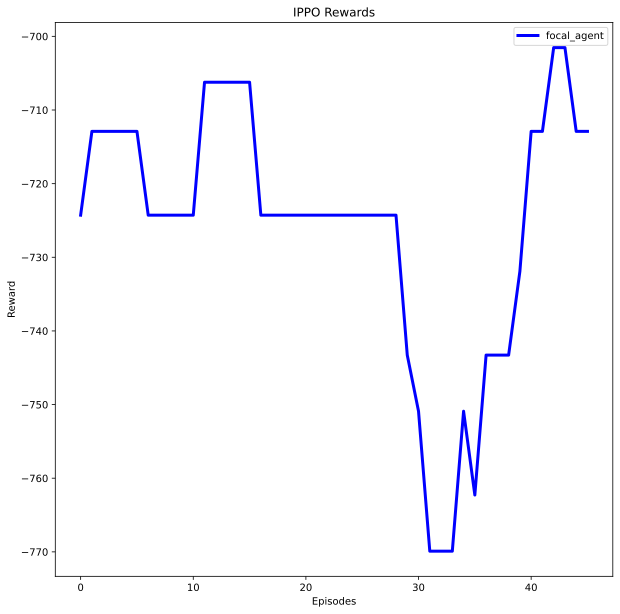

In [25]:
# true_traj_refine[-1][0]
window_size = 5
moving_avg_rewards = [[] for _ in range(data['agent']['num_nodes'])]


for j in range(len(cumulative_reward[agent_index]['return'])-window_size+1):
    window = cumulative_reward[agent_index]['return'][j:j+window_size]
    avg_reward = np.mean(window)
    moving_avg_rewards[agent_index].append(avg_reward)
      

colors = ['blue', 'red', 'green', 'purple', 'orange', 'pink', 'brown', 'gray', 'olive', 'yellow']
plt.figure(figsize=(10, 10))
x = range(episodes-window_size+1)

plt.plot(x, moving_avg_rewards[agent_index], color=colors[0], label=f'focal_agent',linewidth = 3)

plt.title('IPPO Rewards')
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()

# plt.figure(figsize=(10, 10))
# for i in range(data['agent']['num_nodes']):
#     plt.plot(range(num_episodes), loss_list[i], color=colors[i])
# plt.savefig(f'/home/guanren/MA-generative-model/figures/loss/loss_{time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())}.png')
# plt.close()

traj_propose=final_traj_propose
traj_refine=final_traj_refine
reg_mask = data['agent']['predict_mask'][:, model.num_historical_steps:]
cls_mask = data['agent']['predict_mask'][:, -1]

In [ ]:
plot_traj(50.0)
for i in range(6):
    xy = true_traj_refine[[data["agent"]["category"] == 2]][0].cpu().detach()
    plt.plot(xy[i, ..., 0], xy[i, ..., 1])
# for i in range(6):
#     xy = new_position[1][data["agent"]["category"] == 3][0].cpu().detach()
#     plt.plot(xy[i, ..., 0], xy[i, ..., 1])


In [ ]:
[x.value for x in _STATIC_OBJECT_TYPES]

In [ ]:
import math
data['agent']['position'][data['agent']['category']==3][0,45]
print(data['agent']['category']==3)
print(torch.nonzero(data['agent']['category']==3,as_tuple=False).item())

/tmp/ipykernel_205390/1622738850.py:243: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  vehicle_bounding_box = Rectangle(


torch.Size([1, 2])
1


RuntimeError: The expanded size of the tensor (60) must match the existing size (5) at non-singleton dimension 1.  Target sizes: [30, 60, 2].  Tensor sizes: [5, 2]

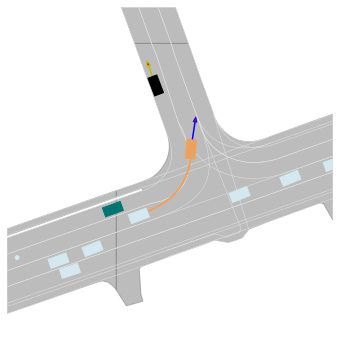

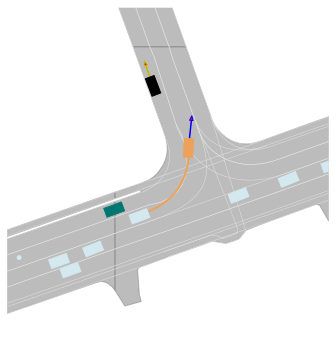

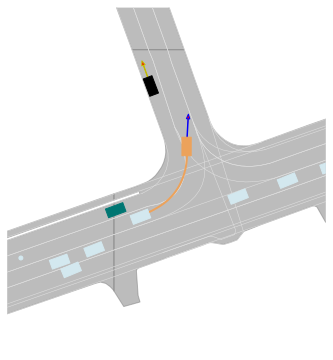

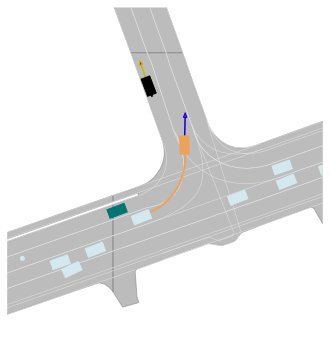

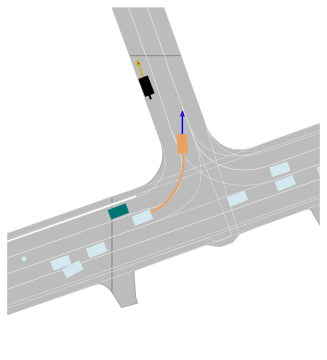

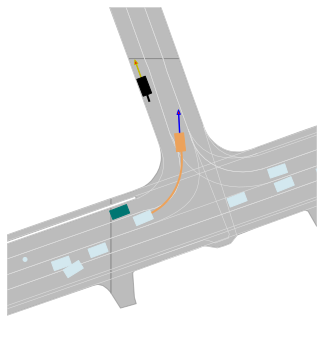

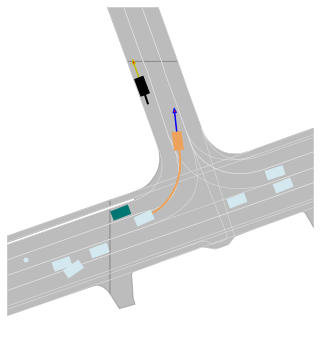

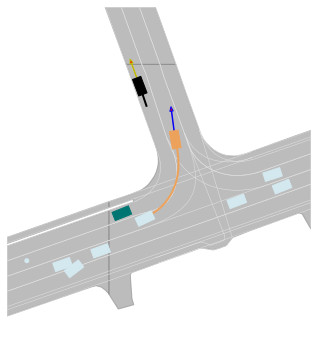

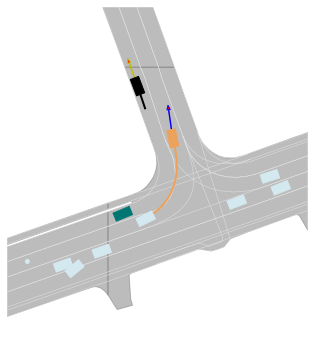

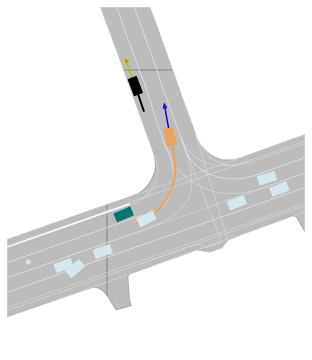

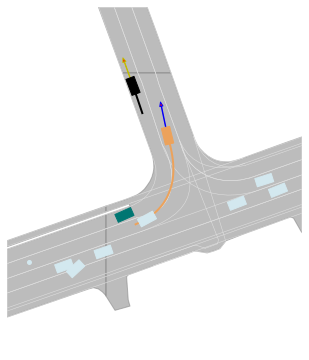

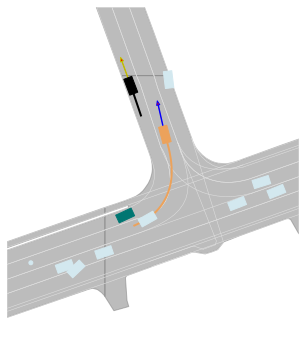

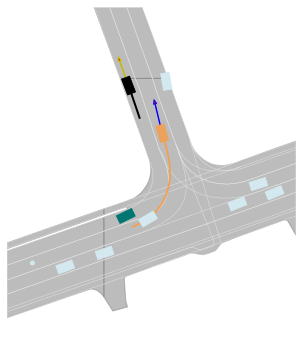

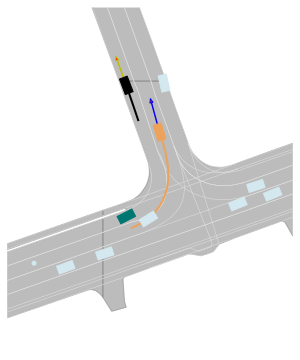

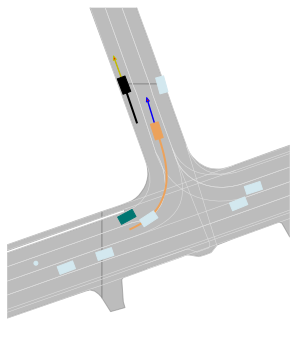

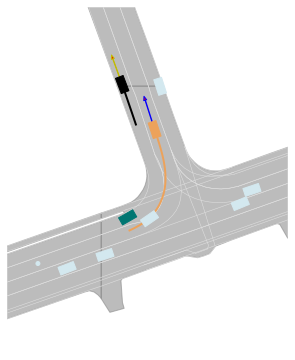

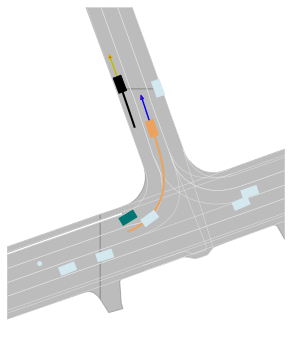

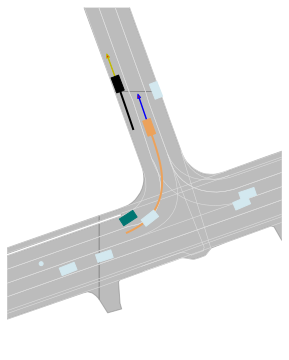

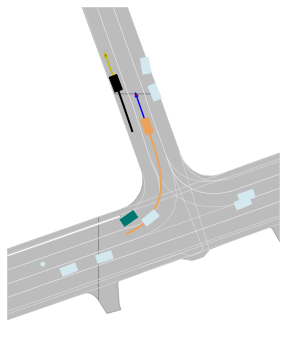

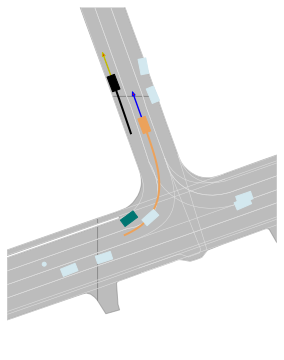

In [29]:
frames = []

with open("configs/PPO.yaml", "r") as file:
        config = yaml.safe_load(file)
file.close()

with torch.no_grad():
        offset=5
        new_data=new_input_data.cuda().clone()
        pred = model(new_data)
        traj_propose = torch.cat([pred['loc_propose_pos'][..., :model.output_dim],
                                pred['scale_propose_pos'][..., :model.output_dim]], dim=-1)
        traj_refine = torch.cat([pred['loc_refine_pos'][..., :model.output_dim],
                                pred['scale_refine_pos'][..., :model.output_dim]], dim=-1)
        auto_pred=pred

        for i in range(30,110):
          if i<50:
              plot_traj_with_data(new_data,bounds=30,t=i)
          else:
              if i%offset==0:
                  # true_trans_position_propose=new_true_trans_position_propose
                  true_trans_position_refine=new_true_trans_position_refine
                  # reg_mask = new_data['agent']['predict_mask'][:, model.num_historical_steps:]
                  # cls_mask = new_data['agent']['predict_mask'][:, -1]
                  # gt = torch.cat([data['agent']['target'][...,timestep:timestep+offset, :model.output_dim], data['agent']['target'][...,timestep:timestep+offset, -1:]], dim=-1)
                  # l2_norm = (torch.norm(traj_propose[:-1,...,:offset, :model.output_dim] -
                  #                     gt[..., :model.output_dim].unsqueeze(1), p=2, dim=-1) * reg_mask[:-1,...,:offset].unsqueeze(1)).sum(dim=-1)
                  # best_mode = l2_norm.argmin(dim=-1)
                  best_mode=torch.randint(1,size=(new_input_data['agent']['num_nodes'],))

                  transition_list = [{'states': [],
                    'actions': [],
                    'next_states': [],
                    'rewards': [],
                    'dones': []} for _ in range(new_data['agent']['num_nodes'])]
                
                  agent_index = torch.nonzero(new_data['agent']['category']==3,as_tuple=False).item()
                  state = new_data['agent']['position'][agent_index, model.num_historical_steps - offset : model.num_historical_steps, :model.output_dim]
                  state = torch.cat([state, new_data['agent']['velocity'][agent_index, model.num_historical_steps - offset : model.num_historical_steps, :model.output_dim]], dim = -1)
                  next_state = new_data['agent']['position'][agent_index, model.num_historical_steps : model.num_historical_steps + offset, :model.output_dim]
                  next_state = torch.cat([next_state, new_data['agent']['velocity'][agent_index, model.num_historical_steps : model.num_historical_steps + offset, :model.output_dim]], dim = -1)
                      
                  action = new_data['agent']['heading'][agent_index, model.num_historical_steps - offset : model.num_historical_steps]
                  acceleration = (new_data['agent']['velocity'][agent_index, model.num_historical_steps : model.num_historical_steps + offset, :model.output_dim] - new_data['agent']['velocity'][agent_index, model.num_historical_steps - offset: model.num_historical_steps, :model.output_dim])/(0.1*offset)
                  action = torch.cat([action.unsqueeze(-1), acceleration],dim=-1)
                  # a = (a-torch.min(a))/(torch.max(a)-torch.min(a))
                  # a = 2 * a - 1

                  transition_list[agent_index]['states'].append(state)
                  transition_list[agent_index]['actions'].append(action)
                  transition_list[agent_index]['next_states'].append(next_state)

                  transition_list[agent_index]['dones'].append(False)
                  reward = reward_function(new_data, agent_index, offset)
                  transition_list[agent_index]['rewards'].append(reward)
                          

                  new_data, auto_pred, _, _, (true_trans_position_propose, true_trans_position_refine),(traj_propose, traj_refine) = get_auto_pred(
                      new_data, auto_pred["loc_refine_pos"][torch.arange(traj_propose.size(0)),best_mode], auto_pred["loc_refine_head"][torch.arange(traj_propose.size(0)),best_mode,:,0], offset,anchor=(init_origin,init_theta,init_rot_mat)
                  )
                  # true_traj_refine[:,:,timestep:timestep+offset,:2]=new_data["agent"]["position"][...,model.num_historical_steps - offset : model.num_historical_steps,:2].unsqueeze(1)
                  pi = auto_pred['pi']

                  plot_traj_with_data(new_data,bounds=30,t=50-offset)
              else:
                  plot_traj_with_data(new_data,bounds=30,t=50-offset+i%offset)
              for j in range(6):
                  xy = true_trans_position_refine[new_data["agent"]["category"] == 3][0].cpu()
                  plt.plot(xy[j, ..., 0], xy[j, ..., 1])

        agent_index = torch.nonzero(new_data['agent']['category']==3,as_tuple=False).item()

        # agent = PPO(
        #         batch_id=0,
        #         encoder = model.encoder,
        #         decoder = model.decoder,
        #         data = new_data.clone().cuda(),
        #         agent_index = agent_index,
        #         hidden_dim = config['hidden_dim'],
        #         action_dim = model.output_dim+1,
        #         state_dim = model.output_dim*2,
        #         actor_learning_rate = config['actor_learning_rate'],
        #         critic_learning_rate = config['critic_learning_rate'],
        #         lamda = config['lamda'],
        #         eps = config['eps'],
        #         gamma = config['gamma'],
        #         device = model.device,
        #         agent_num = new_data['agent']['num_nodes'],
        #         offset = offset,
        #         entropy_coef=config['entropy_coef'],
        #         epochs = config['epochs']
        # )
                
        # agent.update(transition_list,agent_index)

        buf = io.BytesIO()
        plt.savefig(buf, format="png")
        plt.close()
        buf.seek(0)
        frame = img.open(buf)
        frames.append(frame)
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
vid_path = "test_ppo.mp4"
video = cv2.VideoWriter(vid_path, fourcc, fps=10, frameSize=frames[0].size)
for i in range(len(frames)):
    frame_temp = frames[i].copy()
    video.write(cv2.cvtColor(np.array(frame_temp), cv2.COLOR_RGB2BGR))
video.release()

        